In [1]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [2]:
import sys, random, os
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")

from ensemble_boxes import *
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval, DetBenchTrain
from effdet.efficientdet import HeadNet

from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.faster_rcnn import FasterRCNN
import torchvision.transforms as transforms

device = torch.device('cuda')

SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [3]:
# TTA

def get_valid_transforms_effdet():
    return A.Compose([
#             A.ToGray(p=0.5),
#             A.HorizontalFlip(p=0.5),
#             A.VerticalFlip(p=0.5),
#             A.RandomBrightnessContrast(p=0.5),
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

def get_valid_transforms_frcnn():
    return A.Compose([
#             A.ToGray(p=0.5),
#             A.HorizontalFlip(p=0.5),
#             A.VerticalFlip(p=0.5),
#             A.RandomBrightnessContrast(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.0)

def collate_fn(batch):
    return tuple(zip(*batch))


# TTA augs

# class BaseWheatTTA:
#     """ author: @shonenkov """
#     image_size = 512

#     def augment(self, image):
#         raise NotImplementedError
    
#     def batch_augment(self, images):
#         raise NotImplementedError
    
#     def deaugment_boxes(self, boxes):
#         raise NotImplementedError

# class TTAContrastBrightness(BaseWheatTTA):
#     """ author: @ffares """

#     def augment(self, image):
#         alpha = round(random.uniform(1, 1.3),2) # Contrast control// alpha value [1.0-3.0]
#         beta = round(random.uniform(0, 0.2),2)  # Brightness control// beta value [0-100]
#         return torch.clamp(torch.add(torch.mul(image,alpha),beta),0, 1, out=None)
    
#     def batch_augment(self, images):
#         alpha = round(random.uniform(1, 1.3),2) # Contrast control// alpha value [1.0-3.0]
#         beta = round(random.uniform(0, 0.2),2)  # Brightness control// beta value [0-100]
#         return torch.clamp(torch.add(torch.mul(images,alpha),beta),0, 255, out=None)
    
#     def deaugment_boxes(self, boxes):
#         return boxes
        
# class TTAHorizontalFlip(BaseWheatTTA):
#     """ author: @shonenkov """

#     def augment(self, image):
#         return image.flip(1)
    
#     def batch_augment(self, images):
#         return images.flip(2)
    
#     def deaugment_boxes(self, boxes):
#         boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
#         return boxes

# class TTAVerticalFlip(BaseWheatTTA):
#     """ author: @shonenkov """
    
#     def augment(self, image):
#         return image.flip(2)
    
#     def batch_augment(self, images):
#         return images.flip(3)
    
#     def deaugment_boxes(self, boxes):
#         boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
#         return boxes
    
# class TTARotate90(BaseWheatTTA):
#     """ author: @shonenkov """
    
#     def augment(self, image):
#         return torch.rot90(image, 1, (1, 2))

#     def batch_augment(self, images):
#         return torch.rot90(images, 1, (2, 3))
    
#     def deaugment_boxes(self, boxes):
#         res_boxes = boxes.copy()
#         res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
#         res_boxes[:, [1,3]] = boxes[:, [2,0]]
#         return res_boxes
    
# class TTARotate180(BaseWheatTTA):
#     """ author: @shonenkov """
    
#     def augment(self, image):
#         return torch.rot90(image, 2, (1, 2))

#     def batch_augment(self, images):
#         return torch.rot90(images, 2, (2, 3))
    
#     def deaugment_boxes(self, boxes):
#         boxes[:, [0,1,2,3]] = self.image_size - boxes[:, [2,3,0,1]]
#         return boxes
    
# class TTARotate270(BaseWheatTTA):
#     """ author: @shonenkov """
    
#     def augment(self, image):
#         return torch.rot90(image, 3, (1, 2))

#     def batch_augment(self, images):
#         return torch.rot90(images, 3, (2, 3))
    
#     def deaugment_boxes(self, boxes):
#         res_boxes = boxes.copy()
#         res_boxes[:, [0,2]] = boxes[:, [1,3]]
#         res_boxes[:, [1,3]] = self.image_size - boxes[:, [2,0]]
#         return res_boxes
    
# class TTACompose(BaseWheatTTA):
#     """ author: @shonenkov """
#     def __init__(self, transforms):
#         self.transforms = transforms
        
#     def augment(self, image):
#         for transform in self.transforms:
#             image = transform.augment(image)
#         return image
    
#     def batch_augment(self, images):
#         for transform in self.transforms:
#             images = transform.batch_augment(images)
#         return images
    
#     def prepare_boxes(self, boxes):
#         result_boxes = boxes.copy()
#         result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
#         result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
#         result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
#         result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
#         return result_boxes
    
#     def deaugment_boxes(self, boxes):
#         for transform in self.transforms[::-1]:
#             boxes = transform.deaugment_boxes(boxes)
#         return self.prepare_boxes(boxes)

    
# from itertools import product

# tta_transforms = []
# for tta_combination in product([TTAHorizontalFlip(), None], 
#                                [TTAVerticalFlip(), None],
#                                [TTARotate90(), None]):
#     tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

In [4]:
DATA_ROOT_PATH = '../input/global-wheat-detection/test'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [5]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms_frcnn()
)

data_loader_fr = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms_effdet()
)

data_loader_eff = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

> Load EffDets

In [9]:
# # load model

# def get_net():
#     config = get_efficientdet_config('tf_efficientdet_d3')
#     net = EfficientDet(config, pretrained_backbone=False)
#     config.num_classes = 1
#     config.image_size = 512
#     net.class_net = HeadNet(config, num_outputs=1, norm_kwargs=dict(eps=.001, momentum=.01))
#     return DetBenchTrain(net, config)
    
# effdet = get_net()
# effdet.to(device)

# config = get_efficientdet_config('tf_efficientdet_d3')

In [33]:
# load weights

checkpoint = torch.load('../input/wheatmymodelsw/best-checkpointEffD3-069epoch.bin')
weights = checkpoint['model_state_dict']

def load_net(my_weights):
    config = get_efficientdet_config('tf_efficientdet_d3')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    net.load_state_dict(my_weights)

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

eff_detd3 = load_net(weights)
print('done')

done


In [34]:
# load weights

chkpt = torch.load('../input/wheatmymodelsw/best-checkpointEffD5-016epoch.bin')
weights = chkpt['model_state_dict']
def load_net(my_weights):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    net.load_state_dict(my_weights)

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

eff_detd5_1 = load_net(weights)
print('done')

done


In [35]:
# load weights

chkpt = torch.load('../input/wheatmymodelsw/best-checkpointEffD5-074epoch.bin')
weights = chkpt['model_state_dict']
def load_net(my_weights):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    net.load_state_dict(my_weights)

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

eff_detd5_2 = load_net(weights)
print('done')

done


In [36]:
chkpt = torch.load('../input/wheatdetbestweights/Effd5-best-checkpoint-096epoch.bin/best-checkpoint-096epoch.bin')
weights = chkpt['model_state_dict']
def load_net(my_weights):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    net.load_state_dict(my_weights)

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

eff_detd5_3 = load_net(weights)
print('done')

done


Load Faster R-CNN

In [37]:
backbone = resnet_fpn_backbone('resnet101', pretrained=False)
faster_rcnn = FasterRCNN(backbone, num_classes=2).to(device)

WEIGHTS_FILE = '/kaggle/input/resnet101-faster-r-cnn/fasterrcnn_resnet101fpn.pth'

# Load the trained weights
faster_rcnn.load_state_dict(torch.load(WEIGHTS_FILE))
faster_rcnn.eval()
print('done')

done


In [46]:
models = [
    eff_detd5_3, 
    eff_detd5_2, 
#     eff_detd5_1, 
    eff_detd3
]

In [8]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [26]:
def effdet_organize(predictions, image_index):
    
    boxes = [(prediction[image_index]['boxes']).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
        
    return boxes, scores, labels

def frcnn_organize(outputs, image_id):
    if image_id in outputs.keys():
        
        prediction = outputs[image_id] 
        boxes = prediction['boxes']
        scores = prediction['scores']
        labels = np.ones(prediction['scores'].shape[0]).astype(int)
        return boxes, scores, labels


def make_effdet_predictions(models,images, score_threshold=0.1):
    images = torch.stack(images).cuda().float()
    all_predictions = []
    for net in models:
        with torch.no_grad():
            det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
            result = []
            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                result.append({
                    'boxes': boxes[indexes],
                    'scores': scores[indexes],
                })
            all_predictions.append(result)
    return all_predictions   


def resize_predicitions(predictions): 
    '''
    Resize bboxes of faster rcnn as it predicts bboxes in the range of 1024
    We need to convert to 512
    '''
    for k in predictions.keys():
        predictions[k]['boxes'] = predictions[k]['boxes']/2
        predictions[k]['boxes'] = np.array(predictions[k]['boxes']).astype(np.float32)
        
    return predictions


def make_frcnn_predictions(model ,test_data_loader):
    detection_threshold = 0.5
    results = dict()
    for images, image_ids in test_data_loader:
        
        images = list(image.to(device) for image in images)
        outputs = model(images)
        for i, image_id in enumerate(image_ids):
            
            boxes = outputs[i]['boxes'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            scores = scores[scores >= detection_threshold]

            res = {
                'boxes':  boxes,
                'scores': scores
            }
            results[image_id] = res
    return results

def run_wbf_ensemble(boxes_effdet, boxes_fr, scores_effdet, scores_fr, labels_effdet, labels_fr, iou_thr=0.6, skip_box_thr=0.5, weights=None):    
        
    boxes = [boxes_effdet, boxes_fr]
    scores = [scores_effdet, scores_fr]
    labels = [labels_effdet, labels_fr]
    
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=weights,
                                                                                    iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    return boxes, scores, labels


In [27]:
preds_fr = make_frcnn_predictions(faster_rcnn, data_loader_fr)
print(preds_fr['2fd875eaa']['boxes'][0])
preds_fr = resize_predicitions(preds_fr) # resize them to 512
print(preds_fr['2fd875eaa']['boxes'][0])

[393 793 468 881]
[196.5 396.5 234.  440.5]


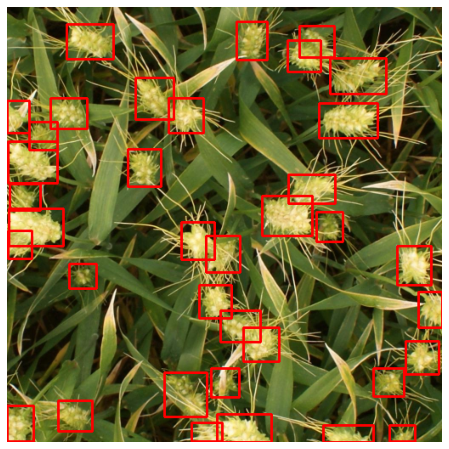

In [28]:
# show faster rcnn predict

import matplotlib.pyplot as plt
for images, image_ids in data_loader_fr:
    detection_threshold = 0.5
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for im_id,im in zip(image_ids, images):
        sample = im
        sample = sample.permute(1,2,0).cpu().numpy()
        sample = cv2.resize(sample, (512, 512))
        output = preds_fr[im_id]
        boxes = output['boxes']
        break

    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)   
    ax.set_axis_off()
    ax.imshow(sample)
    break

In [47]:
# make all fr prediction
preds_fr = make_frcnn_predictions(faster_rcnn, data_loader_fr)
preds_fr = resize_predicitions(preds_fr) # resize them to 512

for images, image_ids in data_loader_eff:
    preds_eff = make_effdet_predictions(models,images)
    for i, image in enumerate(images):
        image_id=image_ids[i]
        boxes_fr,scores_fr, labels_fr = frcnn_organize(preds_fr, image_id)
        boxes_effdet, scores_effdet, labels_effdet = effdet_organize(preds_eff, image_index=i)
        boxes, scores, labels = run_wbf_ensemble(boxes_effdet[0], boxes_fr, scores_effdet[0],scores_fr, labels_effdet[0],
                                                 labels_fr, iou_thr=0.4, skip_box_thr=0.43, weights=None)
        break
    break    
# fr_pred_resize[:2]

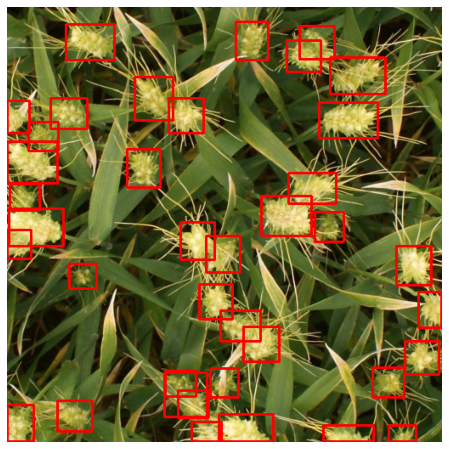

In [48]:
# sample ensemble prediction

import matplotlib.pyplot as plt
for images, image_ids in data_loader_fr:
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for im_id,img in zip(image_ids, images):
        if im_id == image_id:
            img = img.permute(1,2,0).cpu().numpy()
            img = cv2.resize(img, (512, 512))
            for box in aboxes:
                 cv2.rectangle(img,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)               
            ax.set_axis_off()
            ax.imshow(img)   
            break
    break   

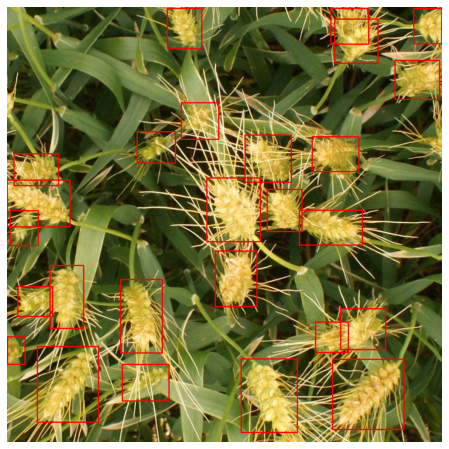

In [164]:
# show faster rcnn predict

import matplotlib.pyplot as plt
for images, image_ids in data_loader_fr:
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    detection_threshold = 0.5
    images = list(image.to(device) for image in images)
    outputs = faster_rcnn(images)
    
    sample = images[1].permute(1,2,0).cpu().numpy()
#     sample = cv2.resize(sample, (512, 512))
#     outputs[1]['boxes']=outputs[1]['boxes']/2
    boxes = outputs[1]['boxes'].data.cpu().numpy()
    scores = outputs[1]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)   
    ax.set_axis_off()
    ax.imshow(sample)
    break

In [ ]:
# results = []

# for images, image_ids in data_loader:
#     predictions = make_predictions(new_model, images)
#     print(predictions)
#     break
#     for i, image in enumerate(images):
#         boxes, scores, labels = run_wbf(predictions, image_index=i)
#         boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
#         image_id = image_ids[i]
        
#         boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
#         boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

#         result = {
#             'image_id': image_id,
#             'PredictionString': format_prediction_string(boxes, scores)
#         }
#         results.append(result)

In [ ]:
results = []

for images, image_ids in data_loader:
    
    predictions = make_predictions(eff_det, images)
    images = list(image.to(device) for image in images)
    outputs = faster_rcnn(images)
    
    for i, image in enumerate(images):

        boxes, scores, labels = run_wbf(predictions,outputs, image_index=i)
        boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
  
        results.append(result)
    break 

In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()